In [1]:
import platform
 
def TestPlatform( ):
    print ("----------Operation System--------------------------")
    #  获取Python版本
    print (platform.python_version())
 
    #   获取操作系统可执行程序的结构，，(’32bit’, ‘WindowsPE’)
    print (platform.architecture())
 
    #   计算机的网络名称，’acer-PC’
    print (platform.node())
 
    #获取操作系统名称及版本号，’Windows-7-6.1.7601-SP1′
    print (platform.platform()) 
 
    #计算机处理器信息，’Intel64 Family 6 Model 42 Stepping 7, GenuineIntel’
    print (platform.processor())
 
    # 获取操作系统中Python的构建日期
    print (platform.python_build())
 
    #  获取系统中python解释器的信息
    print (platform.python_compiler())
 
    if platform.python_branch()=="":
        print (platform.python_implementation())
        print (platform.python_revision())
    print (platform.release())
    print (platform.system())
 
    #print platform.system_alias()
    #  获取操作系统的版本
    print (platform.version())
 
    #  包含上面所有的信息汇总
    print (platform.uname())
    
TestPlatform()


----------Operation System--------------------------
3.10.4
('64bit', 'ELF')
localhost.localdomain
Linux-3.10.0-1160.42.2.el7.x86_64-x86_64-with-glibc2.17
x86_64
('main', 'Mar 31 2022 08:41:55')
GCC 7.5.0
CPython

3.10.0-1160.42.2.el7.x86_64
Linux
#1 SMP Tue Sep 7 14:49:57 UTC 2021
uname_result(system='Linux', node='localhost.localdomain', release='3.10.0-1160.42.2.el7.x86_64', version='#1 SMP Tue Sep 7 14:49:57 UTC 2021', machine='x86_64')


In [2]:
# 1.导入包以及设置随机种子
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
# 2.以类的方式定义超参数
class argparse():
    pass

args = argparse()
args.device, = [torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),]

# 固定参数
args.input_size = 34        #输入大小，固定值
args.output_size = 24       #输出大小，固定值
args.patience = 4           #early stopping相关，暂时忽略

# 可优化参数
args.epochs = 100          
args.learning_rate = 0.005  
args.batch_size = 16        
args.hidden_size = 20       
args.num_layers = 3          

In [4]:
# 3.定义模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(args.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(args.device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0)) # output(5, 30, 64)
        pred = self.linear(output)  # (5, 30, 1)
        pred = pred[:, -1, :]  # (5, 1)
        return pred

In [5]:
# 4.定义early stopping
class EarlyStopping():
    def __init__(self,patience=7,verbose=False,delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        
    def __call__(self,val_loss,model,path):
        print("val_loss={}".format(val_loss))
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss,model,path)
        elif score < self.best_score+self.delta:
            self.counter+=1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter>=self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss,model,path)
            self.counter = 0
            
    def save_checkpoint(self,val_loss,model,path):
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'/'+'model_earlystopping.pth')
        self.val_loss_min = val_loss

In [5]:
# 5.定义自己的数据集Dataset,DataLoader

################## pandas数据读取与处理



### 示例数据，电力负荷，前一天的29个值与预测日的5个气象值作为输入(34)，预测日的24个负荷值做输出(24)

# 读数据
data_full = pd.read_excel("/data1/zhangzt/dev/psolstm/dataset.xls")

# X和y
input = pd.concat([data_full.iloc[0,1:], data_full.iloc[1,1:6]])
output = data_full.iloc[0+1,6:]

for i in range(1, len(data_full) - 1):
    input = pd.concat([input, pd.concat([data_full.iloc[i,1:], data_full.iloc[i+1,1:6]])], axis=1, ignore_index=True)
    # X_full.append(data_full.iloc[i,1:].join(data_full.iloc[i+1,1:6], lsuffix='_pre', rsuffix='_current', how='inner'))
    output = pd.concat([output, data_full.iloc[i+1,6:]], axis=1, ignore_index=True)
    
X_full = input.T
y_full = output.T

# 归一化scaler
mmScaler = MinMaxScaler(feature_range=(-1,1))

dataset_full = pd.concat([X_full, y_full], axis=1)
dataset_full_np = np.array(dataset_full)
dataset_full_np_mm = mmScaler.fit_transform(dataset_full_np)

# train valid
X_train, y_train =  dataset_full_np_mm[:-args.batch_size,:34], dataset_full_np_mm[:-args.batch_size,34:]
X_valid, y_valid = dataset_full_np_mm[-args.batch_size:,:34], dataset_full_np_mm[-args.batch_size:,34:]

# test
X_test =  dataset_full_np_mm[-1:,:34]

# 中间的1是timestep
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

class Dataset_train(Dataset):
    def __init__(self):     
        self.X_full = torch.tensor(X_train.astype(float))
        self.y_full = torch.tensor(np.array(y_train).astype(float))

    def __getitem__(self, index):
        return self.X_full[index], self.y_full[index]
    
    def __len__(self):
        return len(self.X_full)
    
class Dataset_valid(Dataset):
    def __init__(self):     
        self.X_full = torch.tensor(X_valid.astype(float))
        self.y_full = torch.tensor(np.array(y_valid).astype(float))

    def __getitem__(self, index):
        return self.X_full[index], self.y_full[index]
    
    def __len__(self):
        return len(self.X_full)
    
data_train = Dataset_train()
data_valid = Dataset_valid()

# data_loader_train = DataLoader(data_train, batch_size=4, shuffle=False, drop_last=True)
# data_loader_valid = DataLoader(data_valid, batch_size=4, shuffle=False, drop_last=True)
data_loader_train = DataLoader(data_train, batch_size=args.batch_size, shuffle=False)
data_loader_valid = DataLoader(data_valid, batch_size=args.batch_size, shuffle=False)

In [53]:
# 6.实例化模型，设置loss，优化器等
model = LSTM(input_size=args.input_size, hidden_size=args.hidden_size, num_layers=args.num_layers, output_size=args.output_size, batch_size=args.batch_size).to(args.device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=args.learning_rate)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [54]:
# 7.训练
for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(data_loader_train,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = model(data_x)
        optimizer.zero_grad()
        loss = criterion(data_y,outputs)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(data_loader_train)//2)==0:
            print("epoch={}/{},{}/{}of train, loss={}".format(
                epoch, args.epochs, idx, len(data_loader_train),loss.item()))
    train_epochs_loss.append(np.average(train_epoch_loss))
    
    #=====================valid============================
    model.eval()
    valid_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(data_loader_valid,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = model(data_x)
        loss = criterion(outputs,data_y)
        valid_epoch_loss.append(loss.item())
        valid_loss.append(loss.item())
    valid_epochs_loss.append(np.average(valid_epoch_loss))
    #==================early stopping======================
    # early_stopping(valid_epochs_loss[-1],model=model,path='/data1/zhangzt/dev/psolstm')
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
    #====================adjust lr========================
    # lr_adjust = {
    #         2: 5e-8, 4: 1e-8, 6: 5e-9, 8: 1e-9,
    #         10: 5e-10, 15: 1e-10, 20: 5e-11
    #     }
    # if epoch in lr_adjust.keys():
    #     lr = lr_adjust[epoch]
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] = lr
    #     print('Updating learning rate to {}'.format(lr))

epoch=0/100,0/5of train, loss=0.19710209965705872
epoch=0/100,2/5of train, loss=0.1770237386226654
epoch=0/100,4/5of train, loss=0.22329579293727875
epoch=1/100,0/5of train, loss=0.17514333128929138
epoch=1/100,2/5of train, loss=0.14508561789989471
epoch=1/100,4/5of train, loss=0.2142425775527954
epoch=2/100,0/5of train, loss=0.15473031997680664
epoch=2/100,2/5of train, loss=0.1338704228401184
epoch=2/100,4/5of train, loss=0.21381770074367523
epoch=3/100,0/5of train, loss=0.1271866261959076
epoch=3/100,2/5of train, loss=0.10775791108608246
epoch=3/100,4/5of train, loss=0.20872139930725098
epoch=4/100,0/5of train, loss=0.11559587717056274
epoch=4/100,2/5of train, loss=0.0835987851023674
epoch=4/100,4/5of train, loss=0.21322724223136902
epoch=5/100,0/5of train, loss=0.08904384076595306
epoch=5/100,2/5of train, loss=0.0733245462179184
epoch=5/100,4/5of train, loss=0.20976856350898743
epoch=6/100,0/5of train, loss=0.07433367520570755
epoch=6/100,2/5of train, loss=0.03794549033045769
epoch=

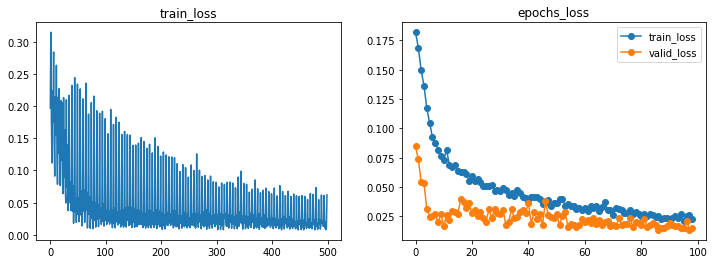

In [55]:
# 8.绘图
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss[1:],'-o',label="train_loss")
plt.plot(valid_epochs_loss[1:],'-o',label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.savefig("/data1/zhangzt/dev/psolstm/manual.png",dpi=800,bbox_inches = 'tight')
plt.show()

In [56]:
print(min(valid_epochs_loss))

0.013415000401437283


In [21]:
# 9.预测
# 此处可定义一个预测集的Dataloader。也可以直接将你的预测数据reshape,添加batch_size=1
model.eval()
# predict = model(data)
torch.save(model.state_dict(), '/data1/zhangzt/dev/psolstm/model_manual.pth')
# for idx,(data_x,data_y) in enumerate(data_loader_test,0):
#         data_x = data_x.to(torch.float32).to(args.device)
#         data_y = data_y.to(torch.float32).to(args.device)
#         outputs = model(data_x)
#         loss = criterion(outputs,data_y)
        
# print(loss)

In [22]:
# 10.PSO寻优算法
#
# 10.1 define PSO
class PSO(object):
    def __init__(self,particle_num,particle_dim,iter_num,c1,c2,w,max_value,min_value):
        '''参数初始化
        particle_num(int):粒子群的粒子数量
        particle_dim(int):粒子维度，对应待寻优参数的个数
        iter_num(int):最大迭代次数
        c1(float):局部学习因子，表示粒子移动到该粒子历史最优位置(pbest)的加速项的权重
        c2(float):全局学习因子，表示粒子移动到所有粒子最优位置(gbest)的加速项的权重
        w(float):惯性因子，表示粒子之前运动方向在本次方向上的惯性
        max_value(float):参数的最大值
        min_value(float):参数的最小值
        '''
        self.particle_num = particle_num ##
        self.particle_dim = particle_dim ##本例中使用2个，分别对应[hidden_size, learning_rate]
        self.iter_num = iter_num
        self.c1 = c1  ##通常设为2.0
        self.c2 = c2  ##通常设为2.0
        self.w = w    
        self.max_value = max_value ##200
        self.min_value = min_value ##0
        
        
# 10.2 initial particle swarm
    def swarm_origin(self):
        '''粒子群初始化
        input:self(object):PSO类
        output:particle_loc(list):粒子群位置列表
               particle_dir(list):粒子群方向列表
        '''
        particle_loc = []
        particle_dir = []
        for i in range(self.particle_num):
            tmp1 = []
            tmp2 = []
            for j in range(self.particle_dim):
                a = random.random()
                b = random.random()
                tmp1.append(a * (self.max_value - self.min_value) + self.min_value)
                tmp2.append(b)
            particle_loc.append(tmp1)
            particle_dir.append(tmp2)
        
        return particle_loc,particle_dir

# 10.3 计算适应度函数数值列表;初始化pbest_parameters和gbest_parameter   
    def fitness(self,particle_loc):
        '''计算适应度函数值
        input:self(object):PSO类
              particle_loc(list):粒子群位置列表
        output:fitness_value(list):适应度函数值列表
        '''
        train_loss = []
        valid_loss = []
        train_epochs_loss = []
        valid_epochs_loss = []
        fitness_value = []
        ### 1.适应度函数为loss值
        for i in range(self.particle_num):
            print(f"{i}/{self.particle_num} particle.")
            criterion = torch.nn.MSELoss()
            lst = LSTM(input_size=args.input_size, hidden_size=int(particle_loc[i][0])+2, num_layers=args.num_layers, output_size=args.output_size, batch_size=args.batch_size).to(args.device)
            opti = torch.optim.Adam(lst.parameters(),lr=particle_loc[i][1])
            # for epoch in range(args.epochs):
            for epoch in range(40):
                lst.train()
                train_epoch_loss = []
                for idx,(data_x,data_y) in enumerate(data_loader_train,0):
                    data_x = data_x.to(torch.float32).to(args.device)
                    data_y = data_y.to(torch.float32).to(args.device)
                    outputs = lst(data_x)
                    opti.zero_grad()
                    loss = criterion(data_y,outputs)
                    loss.backward()
                    opti.step()
                    train_epoch_loss.append(loss.item())
                    train_loss.append(loss.item())
                    # if idx%(len(data_loader_train)//2)==0:
                    #     print("epoch={}/{},{}/{}of train, loss={}".format(
                    #         epoch, 40, idx, len(data_loader_train),loss.item()))
                train_epochs_loss.append(np.average(train_epoch_loss))
            # rbf_svm = svm.SVC(kernel = 'rbf', C = particle_loc[i][0], gamma = particle_loc[i][1])
            # cv_scores = cross_validation.cross_val_score(rbf_svm,trainX,trainY,cv =3,scoring = 'accuracy')
            fitness_value.append(-train_epochs_loss[-1])
        ### 2. 当前粒子群最优适应度函数值和对应的参数
        current_fitness = -1000.0
        current_parameter = []
        for i in range(self.particle_num):
            if current_fitness < fitness_value[i]:
                current_fitness = fitness_value[i]
                current_parameter = particle_loc[i]

        return fitness_value,current_fitness,current_parameter 
        

## 10.4  粒子位置更新 
    def updata(self,particle_loc,particle_dir,gbest_parameter,pbest_parameters):
        '''粒子群位置更新
        input:self(object):PSO类
              particle_loc(list):粒子群位置列表
              particle_dir(list):粒子群方向列表
              gbest_parameter(list):全局最优参数
              pbest_parameters(list):每个粒子的历史最优值
        output:particle_loc(list):新的粒子群位置列表
               particle_dir(list):新的粒子群方向列表
        '''
        ## 1.计算新的量子群方向和粒子群位置
        for i in range(self.particle_num): 
            a1 = [x * self.w for x in particle_dir[i]]
            a2 = [y * self.c1 * random.random() for y in list(np.array(pbest_parameters[i]) - np.array(particle_loc[i]))]
            a3 = [z * self.c2 * random.random() for z in list(np.array(gbest_parameter) - np.array(particle_dir[i]))]
            particle_dir[i] = list(np.array(a1) + np.array(a2) + np.array(a3))
            # particle_dir[i] = self.w * particle_dir[i] + self.c1 * random.random() * (pbest_parameters[i] - particle_loc[i]) + self.c2 * random.random() * (gbest_parameter - particle_dir[i])
            particle_loc[i] = list(np.array(particle_loc[i]) + np.array(particle_dir[i]))
            
        ## 2.将更新后的量子位置参数固定在[min_value,max_value]内 
        ### 2.1 每个参数的取值列表
        parameter_list = []
        for i in range(self.particle_dim):
            tmp1 = []
            for j in range(self.particle_num):
                tmp1.append(particle_loc[j][i])
            parameter_list.append(tmp1)
        ### 2.2 每个参数取值的最大值、最小值、平均值   
        value = []
        for i in range(self.particle_dim):
            tmp2 = []
            tmp2.append(max(parameter_list[i]))
            tmp2.append(min(parameter_list[i]))
            value.append(tmp2)
        
        for i in range(self.particle_num):
            for j in range(self.particle_dim):
                particle_loc[i][j] = (particle_loc[i][j] - value[j][1])/(value[j][0] - value[j][1]) * (self.max_value - self.min_value) + self.min_value
                
        return particle_loc,particle_dir

## 10.5 画出适应度函数值变化图
    def plot(self,results):
        '''画图
        '''
        X = []
        Y = []
        for i in range(self.iter_num):
            X.append(i + 1)
            Y.append(results[i])
        plt.plot(X,Y)
        plt.xlabel('Number of iteration',size = 15)
        plt.ylabel('Value of CV',size = 15)
        plt.title('PSO_RBF_SVM parameter optimization')
        plt.savefig("/data1/zhangzt/dev/psolstm/pso.png",dpi=800,bbox_inches = 'tight')
        plt.show() 
        
## 10.6 主函数        
    def main(self):
        '''主函数
        '''
        results = []
        best_fitness = -1000.0 
        ## 1、粒子群初始化
        particle_loc,particle_dir = self.swarm_origin()
        ## 2、初始化gbest_parameter、pbest_parameters、fitness_value列表
        ### 2.1 gbest_parameter
        gbest_parameter = []
        for i in range(self.particle_dim):
            gbest_parameter.append(-1000)
        ### 2.2 pbest_parameters
        pbest_parameters = []
        for i in range(self.particle_num):
            tmp1 = []
            for j in range(self.particle_dim):
                tmp1.append(-1000)
            pbest_parameters.append(tmp1)
        ### 2.3 fitness_value
        fitness_value = []
        for i in range(self.particle_num):
            fitness_value.append(-1000)
    
        ## 3.迭代
        for i in range(self.iter_num):
            print(f"{i}/{self.iter_num} iter of current particle.")
            ### 3.1 计算当前适应度函数值列表
            current_fitness_value,current_best_fitness,current_best_parameter = self.fitness(particle_loc)
            ### 3.2 求当前的gbest_parameter、pbest_parameters和best_fitness
            for j in range(self.particle_num):
                if current_fitness_value[j] > fitness_value[j]:
                    pbest_parameters[j] = particle_loc[j]
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                gbest_parameter = current_best_parameter
            
            print('iteration is :',i+1,';Best parameters:',gbest_parameter,';Best fitness(loss)',best_fitness)
            results.append(best_fitness)
            ### 3.3 更新fitness_value
            fitness_value = current_fitness_value
            ### 3.4 更新粒子群
            particle_loc,particle_dir = self.updata(particle_loc,particle_dir,gbest_parameter,pbest_parameters)
        ## 4.结果展示
        results.sort()
        self.plot(results)
        print('Final parameters are :',gbest_parameter)

In [23]:
pso = PSO(particle_num=100,particle_dim=2,iter_num=50,c1=2,c2=2,w=0.8,max_value=100,min_value=0)

0/50 iter of current particle.
0/100 particle.
1/100 particle.
2/100 particle.
3/100 particle.
4/100 particle.
5/100 particle.
6/100 particle.
7/100 particle.
8/100 particle.
9/100 particle.
10/100 particle.
11/100 particle.
12/100 particle.
13/100 particle.
14/100 particle.
15/100 particle.
16/100 particle.
17/100 particle.
18/100 particle.
19/100 particle.
20/100 particle.
21/100 particle.
22/100 particle.
23/100 particle.
24/100 particle.
25/100 particle.
26/100 particle.
27/100 particle.
28/100 particle.
29/100 particle.
30/100 particle.
31/100 particle.
32/100 particle.
33/100 particle.
34/100 particle.
35/100 particle.
36/100 particle.
37/100 particle.
38/100 particle.
39/100 particle.
40/100 particle.
41/100 particle.
42/100 particle.
43/100 particle.
44/100 particle.
45/100 particle.
46/100 particle.
47/100 particle.
48/100 particle.
49/100 particle.
50/100 particle.
51/100 particle.
52/100 particle.
53/100 particle.
54/100 particle.
55/100 particle.
56/100 particle.
57/100 par

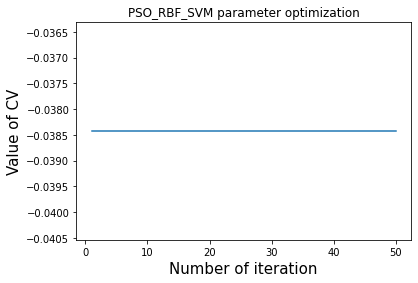

Final parameters are : [30.09498745655653, 0.04059396972875273]


In [24]:
pso.main()

In [65]:
# 11.根据pso得出的参数重新建模
model_2 = LSTM(input_size=args.input_size, hidden_size=32, num_layers=args.num_layers, output_size=args.output_size, batch_size=args.batch_size).to(args.device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(),lr=0.04059396972875273)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [66]:
# 12.重新训练
for epoch in range(args.epochs):
    model_2.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(data_loader_train,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = model_2(data_x)
        optimizer.zero_grad()
        loss = criterion(data_y,outputs)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(data_loader_train)//2)==0:
            print("epoch={}/{},{}/{}of train, loss={}".format(
                epoch, args.epochs, idx, len(data_loader_train),loss.item()))
    train_epochs_loss.append(np.average(train_epoch_loss))
    
    #=====================valid============================
    model_2.eval()
    valid_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(data_loader_valid,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = model_2(data_x)
        loss = criterion(outputs,data_y)
        valid_epoch_loss.append(loss.item())
        valid_loss.append(loss.item())
    valid_epochs_loss.append(np.average(valid_epoch_loss))
    #==================early stopping======================
    # early_stopping(valid_epochs_loss[-1],model=model,path='/data1/zhangzt/dev/psolstm')
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
    #====================adjust lr========================
    # lr_adjust = {
    #         5: 5e-8, 10: 1e-8, 15: 5e-9, 20: 1e-9,
    #         25: 5e-10, 30: 1e-10, 35: 5e-11, 40: 5e-11, 
    #         45: 5e-11, 50: 5e-11, 55: 5e-11, 60: 5e-11, 
    #         65: 5e-11, 70: 5e-11, 75: 5e-11, 80: 5e-11,
    #         85: 5e-11, 90: 5e-11, 95: 5e-11, 98: 5e-11
    #     }
    if epoch // 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.80

epoch=0/100,0/5of train, loss=0.2171570062637329
epoch=0/100,2/5of train, loss=0.12927907705307007
epoch=0/100,4/5of train, loss=0.2049996554851532
epoch=1/100,0/5of train, loss=0.05192837119102478
epoch=1/100,2/5of train, loss=0.02727595716714859
epoch=1/100,4/5of train, loss=0.2834133803844452
epoch=2/100,0/5of train, loss=0.046417754143476486
epoch=2/100,2/5of train, loss=0.024701889604330063
epoch=2/100,4/5of train, loss=0.21883118152618408
epoch=3/100,0/5of train, loss=0.04714348539710045
epoch=3/100,2/5of train, loss=0.020404284819960594
epoch=3/100,4/5of train, loss=0.13941329717636108
epoch=4/100,0/5of train, loss=0.05157140642404556
epoch=4/100,2/5of train, loss=0.012896153144538403
epoch=4/100,4/5of train, loss=0.16606071591377258
epoch=5/100,0/5of train, loss=0.0264405757188797
epoch=5/100,2/5of train, loss=0.011610275134444237
epoch=5/100,4/5of train, loss=0.17855070531368256
epoch=6/100,0/5of train, loss=0.024538446217775345
epoch=6/100,2/5of train, loss=0.0204549096524715

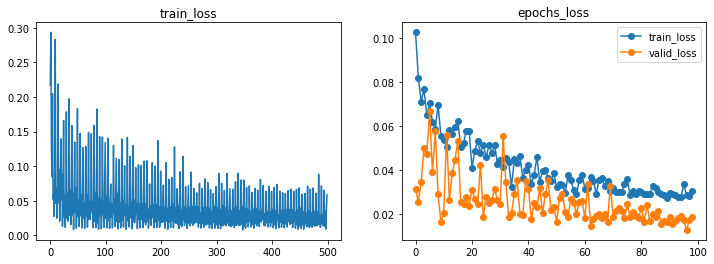

In [67]:
# 13.绘图
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss[1:],'-o',label="train_loss")
plt.plot(valid_epochs_loss[1:],'-o',label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.savefig("/data1/zhangzt/dev/psolstm/psolstm.png",dpi=800,bbox_inches = 'tight')
plt.show()

In [68]:
print(min(valid_epochs_loss))

0.012801284901797771


In [6]:
# 14.与bp的对比
class BPNetModel(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super(BPNetModel, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_seq):
        pred = nn.functional.relu(self.hidden(input_seq)) 
        pred = nn.functional.softmax(self.out(pred),dim=1)
        return pred
    
bp_model=BPNetModel(input_size=args.input_size, hidden_size=32, output_size=args.output_size).to(args.device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(bp_model.parameters(),lr=0.001)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

###########################数据
# 读数据
data_full = pd.read_excel("/data1/zhangzt/dev/psolstm/dataset.xls")

# X和y
input = pd.concat([data_full.iloc[0,1:], data_full.iloc[1,1:6]])
output = data_full.iloc[0+1,6:]

for i in range(1, len(data_full) - 1):
    input = pd.concat([input, pd.concat([data_full.iloc[i,1:], data_full.iloc[i+1,1:6]])], axis=1, ignore_index=True)
    # X_full.append(data_full.iloc[i,1:].join(data_full.iloc[i+1,1:6], lsuffix='_pre', rsuffix='_current', how='inner'))
    output = pd.concat([output, data_full.iloc[i+1,6:]], axis=1, ignore_index=True)
    
X_full = input.T
y_full = output.T

dataset_full = pd.concat([X_full, y_full], axis=1)
dataset_full_np = np.array(dataset_full)
dataset_full_np_mm = mmScaler.transform(dataset_full_np)

# train,valid和test
X_train, y_train =  dataset_full_np_mm[:-args.batch_size,:34], dataset_full_np_mm[:-args.batch_size,34:]
X_valid, y_valid = dataset_full_np_mm[-args.batch_size:,:34], dataset_full_np_mm[-args.batch_size:,34:]

class Dataset_train(Dataset):
    def __init__(self):     
        self.X_full = torch.tensor(X_train.astype(float))
        self.y_full = torch.tensor(np.array(y_train).astype(float))

    def __getitem__(self, index):
        return self.X_full[index], self.y_full[index]
    
    def __len__(self):
        return len(self.X_full)
    
class Dataset_valid(Dataset):
    def __init__(self):     
        self.X_full = torch.tensor(X_valid.astype(float))
        self.y_full = torch.tensor(np.array(y_valid).astype(float))

    def __getitem__(self, index):
        return self.X_full[index], self.y_full[index]
    
    def __len__(self):
        return len(self.X_full)
    
data_train = Dataset_train()
data_valid = Dataset_valid()

# data_loader_train = DataLoader(data_train, batch_size=4, shuffle=False, drop_last=True)
# data_loader_valid = DataLoader(data_valid, batch_size=4, shuffle=False, drop_last=True)
data_loader_train = DataLoader(data_train, batch_size=args.batch_size, shuffle=False)
data_loader_valid = DataLoader(data_valid, batch_size=args.batch_size, shuffle=False)

for epoch in range(args.epochs):
    bp_model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(data_loader_train,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = bp_model(data_x)
        optimizer.zero_grad()
        loss = criterion(data_y,outputs)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(data_loader_train)//2)==0:
            print("epoch={}/{},{}/{}of train, loss={}".format(
                epoch, args.epochs, idx, len(data_loader_train),loss.item()))
    train_epochs_loss.append(np.average(train_epoch_loss))
    
    #=====================valid============================
    bp_model.eval()
    valid_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(data_loader_valid,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = bp_model(data_x)
        loss = criterion(outputs,data_y)
        valid_epoch_loss.append(loss.item())
        valid_loss.append(loss.item())
    valid_epochs_loss.append(np.average(valid_epoch_loss))

epoch=0/100,0/5of train, loss=0.1717524528503418
epoch=0/100,2/5of train, loss=0.15698149800300598
epoch=0/100,4/5of train, loss=0.2049659937620163
epoch=1/100,0/5of train, loss=0.1709991991519928
epoch=1/100,2/5of train, loss=0.15637001395225525
epoch=1/100,4/5of train, loss=0.20473018288612366
epoch=2/100,0/5of train, loss=0.17038142681121826
epoch=2/100,2/5of train, loss=0.1558035910129547
epoch=2/100,4/5of train, loss=0.20450060069561005
epoch=3/100,0/5of train, loss=0.16978585720062256
epoch=3/100,2/5of train, loss=0.15523555874824524
epoch=3/100,4/5of train, loss=0.20427536964416504
epoch=4/100,0/5of train, loss=0.1691729873418808
epoch=4/100,2/5of train, loss=0.15463393926620483
epoch=4/100,4/5of train, loss=0.20404712855815887
epoch=5/100,0/5of train, loss=0.1685173362493515
epoch=5/100,2/5of train, loss=0.1539708822965622
epoch=5/100,4/5of train, loss=0.20380711555480957
epoch=6/100,0/5of train, loss=0.1677926629781723
epoch=6/100,2/5of train, loss=0.1532239317893982
epoch=6/1

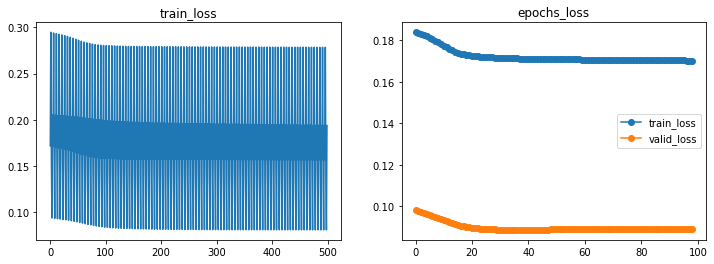

In [7]:
# 15.bp绘图
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss[1:],'-o',label="train_loss")
plt.plot(valid_epochs_loss[1:],'-o',label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.savefig("/data1/zhangzt/dev/psolstm/bp.png",dpi=800,bbox_inches = 'tight')
plt.show()

In [81]:
print(min(valid_epochs_loss))

0.08868624269962311


In [ ]:
# 16. Load weight and predict
def predict(data, pth_file, scaler):
    # input = scaler.transform(data)
    input = torch.tensor(X_train.astype(data))
    model = torch.load(pth_file)
    result = model(input)
    score = scaler.inverse_transform(result)
    return score